# process spectra for AuxTel with new spectractor (version=2.1, November 2022) for particular config for Hologram

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : October 31th 2022
- update : 2022-11-07

- version v3 : Work with exposure butlen gen3

This notebook is to help for finding the position of order 0

CCIN2P3:

- works with kernels **anaconda3_auxtel** (with libradtran) and **anaconda3_auxtel_v2** (no libradtran)
- works with kernel **python 3** locally 



# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
print(sys.path)

['/pbs/throng/lsst/users/dagoret/desc/AuxTelComm/notebookccdm_gen3/runspectractor_standalone/2022_11', '', '/opt/conda/lib/python3.8/site-packages', '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python38.zip', '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8', '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/lib-dynload', '/pbs/home/d/dagoret/.local/lib/python3.8/site-packages', '/pbs/throng/lsst/users/dagoret/desc/firecrown', '/pbs/throng/lsst/users/dagoret/desc/augur', '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages', '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Deprecated-1.2.11-py3.8.egg', '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/docopt-0.6.2-py3.8.egg', '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/mimeparse-0.1.3-py3.8.egg', '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/rail-0.1.dev0-py3.8.egg', '/sps/lss

In [3]:
all_paths_to_remove = ['/opt/conda/lib/python3.8/site-packages','/pbs/home/d/dagoret/.local/lib/python3.8/site-packages']

for path_to_remove in all_paths_to_remove:
    if path_to_remove in sys.path:
        print(f"remove {path_to_remove} from sys.path")
        sys.path.remove(path_to_remove)

remove /opt/conda/lib/python3.8/site-packages from sys.path
remove /pbs/home/d/dagoret/.local/lib/python3.8/site-packages from sys.path


In [4]:
sys.path

['/pbs/throng/lsst/users/dagoret/desc/AuxTelComm/notebookccdm_gen3/runspectractor_standalone/2022_11',
 '',
 '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python38.zip',
 '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8',
 '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/lib-dynload',
 '/pbs/throng/lsst/users/dagoret/desc/firecrown',
 '/pbs/throng/lsst/users/dagoret/desc/augur',
 '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages',
 '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Deprecated-1.2.11-py3.8.egg',
 '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/docopt-0.6.2-py3.8.egg',
 '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/mimeparse-0.1.3-py3.8.egg',
 '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/rail-0.1.dev0-py3.8.egg',
 '/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/pyarrow-4.0.1-py3.8-li

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [6]:
print(sys.executable)
print(sys.version)
#print(sys.version_info)

/sps/lsst/groups/auxtel/softs/utils/anaconda3/bin/python
3.8.13 (default, Oct 21 2022, 23:50:54) 
[GCC 11.2.0]


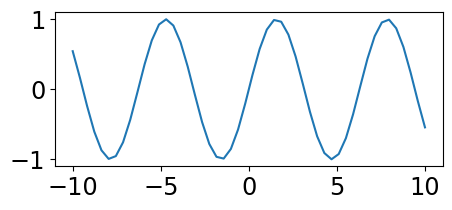

In [7]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               


In [8]:
from iminuit import Minuit
import iminuit

In [9]:
iminuit.__version__

'2.8.4'

In [10]:
import scipy
print(scipy.__version__)

1.7.3


In [11]:
from astropy.io import fits
from astropy.coordinates import Angle
from astropy import units as u
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor,dumpParameters,dumpfitparameters
from spectractor.extractor.images import *
from spectractor.config import load_config, set_logger
from scipy import ndimage, misc

2022-11-07 19:46:14  astropy    _showwarning         WARNING AstropyDeprecationWarning: The update_default_config function is deprecated and may be removed in a future version.


In [12]:
import logging

In [13]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

In [14]:
from distutils.dir_util import copy_tree
import shutil

# Configuration

## Logger

In [15]:
my_logger = logging

## Config for the notebook

In [16]:
version="v5.0"  # version of flipping
# create output directories if not exist and clean existing files
FLAG_MANAGE_OUTPUT_SPECTRACTOR=True
# allow to run reconstruction with Spectractor
FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR=True
FLAG_RUNWITHEXCEPTIONS = False

## Configuration for Spectractor

In [17]:
print("List of configuration files available : ",os.listdir("config"))

List of configuration files available :  ['auxtel_config_holo_DECONVOLUTION_REBIN2FFMvNov2022.ini', '.ipynb_checkpoints', 'auxtel_config_holo_DECONVOLUTION_FFMvNov2022.ini']


In [18]:
# Choose the config filename
list_of_spectractorconfigfiles= ['auxtel_config_holo_DECONVOLUTION_PSF1D.ini' ,
                                 'auxtel_config_holo_DECONVOLUTION_PSF2D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_FFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF2DFFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2FFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DFFM300650.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF2D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotA.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotB.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotC.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotD.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF1D_BG40.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF1DTRUNC.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2FFMvNov2022.ini',
                                 'auxtel_config_holo_DECONVOLUTION_FFMvNov2022.ini']

config_idx = len(list_of_spectractorconfigfiles)-1
                                
configfilename= os.path.join("./config",list_of_spectractorconfigfiles[config_idx])
#configdir = (list_of_spectractorconfigfiles[config_idx].split("_")[-1]).split(".") [0]
configdir = "config_" + (list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_")[-1]).split(".") [0]

In [19]:
configfilename

'./config/auxtel_config_holo_DECONVOLUTION_FFMvNov2022.ini'

In [20]:
configdir

'config_DECONVOLUTION_FFMvNov2022'

In [21]:
! pwd

/pbs/throng/lsst/users/dagoret/desc/AuxTelComm/notebookccdm_gen3/runspectractor_standalone/2022_11


In [22]:
config=configfilename
print(f">>>>> Spectractor configuration filename : {configfilename}")

>>>>> Spectractor configuration filename : ./config/auxtel_config_holo_DECONVOLUTION_FFMvNov2022.ini


In [23]:
load_config(configfilename)

No rebinning: parameters.REBIN is forced to 1.


In [24]:
dumpParameters()

ASTROMETRYNET_DIR 
BGD_ORDER 1
CALIB_BGD_NPARAMS 4
CALIB_BGD_ORDER 3
CALIB_BGD_WIDTH 15
CALIB_PEAK_WIDTH 7
CALIB_SAVGOL_ORDER 2
CALIB_SAVGOL_WINDOW 5
CCD_ARCSEC2RADIANS 4.84813681109536e-06
CCD_GAIN 1.1
CCD_IMSIZE 4096
CCD_MAXADU 170000
CCD_PIXEL2ARCSEC 0.0952
CCD_PIXEL2MM 0.01
CCD_REBIN 1
CONFIG_DIR /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/../config/
DEBUG False
DEBUG_LOGGING False
DISPERSER_DIR /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/
DISPLAY False
DISTANCE2CCD 181
DISTANCE2CCD_ERR 0.4
FGB37 {'label': 'FGB37', 'min': 350, 'max': 750}
FILTERS [{'label': 'RG715', 'min': 690, 'max': 1100}, {'label': 'FGB37', 'min': 350, 'max': 750}, {'label': 'Halfa', 'min': 0.0006431, 'max': 0.0006686999999999999}, {'label': 'Z-Gunn', 'min': 800, 'max': 1100}]
FLAM_TO_ADURATE 5175865186660.421
GRATING_ORDER_2OVER1 0.1
GROOVES_PER_MM 350
HALP

# Exposure config

In [25]:
! ls logbooks

auxtellogbook_FELH0600~holo4_003_20211103_v5.0.csv
auxtellogbook_FELH0600~holo4_003_20211103_v5.0.xlsx


In [26]:
# path index for each month
DATE="20211103"
#DATE="20211104"
#filterdispersername = "empty~holo4_003"
#filterdispersername = "BG40~holo4_003"
filterdispersername = "FELH0600~holo4_003"
imagemode = "postISRCCD"
#imagemode = "unflattened"

In [27]:
disperser_label = filterdispersername.split("~")[-1]

## Paths

In [28]:
# select if we run at CC or not (locally) 
# /sps/lsst/groups/auxtel/data/2022/holo/20220317
HOSTCC=True
LAPTOP=False

In [29]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
    if configdir == "":
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
    else:
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
        path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
        path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
        path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)

else:
    if not LAPTOP:
        path_auxtel="/Users/sylvie/DATA/AuxTelData2022"
        path_spectractor=os.path.join(path_auxtel,"/Users/sylvie/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)
    else:
        path_auxtel="/Users/dagoret/DATA/AuxTelData2022"
        path_spectractor=os.path.join(path_auxtel,"/Users/dagoret/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)
        


In [30]:
path_images

'/sps/lsst/groups/auxtel/data/2022/FELH0600~holo4_003/20211103'

In [31]:
path_topoutput_spectractor

'/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022'

In [32]:
path_output_spectractor

'/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103'

# Utility Functions

In [33]:
def is_nan(x):
    return (x != x)

# Logbook for input file selection

- the logbook contains all input image path and possibily the order 0 position

In [34]:
!ls logbooks

auxtellogbook_FELH0600~holo4_003_20211103_v5.0.csv
auxtellogbook_FELH0600~holo4_003_20211103_v5.0.xlsx


In [35]:
filename_logbook='logbooks/auxtellogbook_'+filterdispersername+"_"+DATE+'_' + version+'.csv'

In [36]:
filename_logbook

'logbooks/auxtellogbook_FELH0600~holo4_003_20211103_v5.0.csv'

In [37]:
df=pd.read_csv(filename_logbook,index_col=0)

In [38]:
pd.set_option('display.max_rows', None)

In [39]:
# show the list of input files from the logbook to select the file index in the logbook
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2021-11-04T05:07:43.370,/sps/lsst/groups/auxtel/data/2022/FELH0600~hol...,exposure_2021110300448_postisrccd.fits,448,HD 37795,FELH0600,holo4_003,1.154825,2.0,...,7.2,33.0,6.8,NaN,NaN,NaN,NaN,,NaN,NaN
1,1,2021-11-04T05:08:20.217,/sps/lsst/groups/auxtel/data/2022/FELH0600~hol...,exposure_2021110300449_postisrccd.fits,449,HD 37795,FELH0600,holo4_003,1.153394,2.0,...,7.2,34.0,4.8,NaN,NaN,NaN,NaN,,NaN,NaN
2,2,2021-11-04T05:08:54.415,/sps/lsst/groups/auxtel/data/2022/FELH0600~hol...,exposure_2021110300450_postisrccd.fits,450,HD 37795,FELH0600,holo4_003,1.151521,2.0,...,7.2,34.0,6.0,NaN,NaN,NaN,NaN,,NaN,NaN
3,3,2021-11-04T05:11:43.527,/sps/lsst/groups/auxtel/data/2022/FELH0600~hol...,exposure_2021110300451_postisrccd.fits,451,HD 37795,FELH0600,holo4_003,1.145281,1.0,...,7.2,33.0,6.3,NaN,NaN,NaN,NaN,,NaN,NaN
4,4,2021-11-04T05:12:19.215,/sps/lsst/groups/auxtel/data/2022/FELH0600~hol...,exposure_2021110300452_postisrccd.fits,452,HD 37795,FELH0600,holo4_003,1.144045,1.0,...,7.2,33.0,6.4,NaN,NaN,NaN,NaN,,NaN,NaN
5,5,2021-11-04T05:12:52.522,/sps/lsst/groups/auxtel/data/2022/FELH0600~hol...,exposure_2021110300453_postisrccd.fits,453,HD 37795,FELH0600,holo4_003,1.142759,1.0,...,7.2,33.0,6.7,NaN,NaN,NaN,NaN,,NaN,NaN
6,6,2021-11-04T05:17:12.323,/sps/lsst/groups/auxtel/data/2022/FELH0600~hol...,exposure_2021110300455_postisrccd.fits,455,HD 38666,FELH0600,holo4_003,1.148628,1.0,...,7.3,33.0,6.3,NaN,NaN,NaN,NaN,,NaN,NaN
7,7,2021-11-04T05:17:52.968,/sps/lsst/groups/auxtel/data/2022/FELH0600~hol...,exposure_2021110300456_postisrccd.fits,456,HD 38666,FELH0600,holo4_003,1.147130,1.0,...,7.3,34.0,6.2,NaN,NaN,NaN,NaN,,NaN,NaN
8,8,2021-11-04T05:25:31.608,/sps/lsst/groups/auxtel/data/2022/FELH0600~hol...,exposure_2021110300462_postisrccd.fits,462,HD 38666,FELH0600,holo4_003,1.129715,30.0,...,7.3,31.0,5.8,NaN,NaN,NaN,NaN,,NaN,NaN
9,9,2021-11-04T05:29:35.261,/sps/lsst/groups/auxtel/data/2022/FELH0600~hol...,exposure_2021110300468_postisrccd.fits,468,HD 38666,FELH0600,holo4_003,1.121020,30.0,...,7.4,32.0,5.8,NaN,NaN,NaN,NaN,,NaN,NaN


# Selection of input file
- the input file is selected from the logbook list above

In [40]:
idx=4

In [41]:
print(df.iloc[idx]['file'])

exposure_2021110300452_postisrccd.fits


In [42]:
print(df.iloc[idx])

index                                                          4
date                                     2021-11-04T05:12:19.215
path           /sps/lsst/groups/auxtel/data/2022/FELH0600~hol...
file                      exposure_2021110300452_postisrccd.fits
num                                                          452
object                                                  HD 37795
filter                                                  FELH0600
disperser                                              holo4_003
airmass                                                 1.144045
exposure                                                     1.0
focus                                                   0.043359
seeing                                                  0.943947
pressure                                                   740.4
temperature                                                  7.2
humidity                                                    33.0
windspd                  

In [43]:
myhome=os.getenv("HOME")

In [44]:
dir_images=path_images

In [45]:
dir_images

'/sps/lsst/groups/auxtel/data/2022/FELH0600~holo4_003/20211103'

In [46]:
filename_image=df['file'][idx]
filename_image

'exposure_2021110300452_postisrccd.fits'

In [47]:
target = df['object'][idx]
target

'HD 37795'

## If order 0 position exists in logbook it is selected, otherwise put it by hand

In [48]:
# ## If order 0 position exists in logbook it is selected, otherwise put it by hand

x0=300
y0=1700

if 'Obj-posXpix' in df.columns and 'Obj-posYpix' in df.columns:
    thex0 = df['Obj-posXpix'][idx]
    if not is_nan(thex0):
        x0=thex0
    they0 = df['Obj-posYpix'][idx]
    if not is_nan(they0):
        y0=they0
    
if not is_nan(x0) and not is_nan(y0):

    print("Order 0 location from logbook : ({},{})".format(x0,y0))
else:
    print("NO Order 0 location from logbook ! ")      

print(f"guess (x0,y0) = ({x0},{y0})")


Order 0 location from logbook : (300,1700)
guess (x0,y0) = (300,1700)


## Spectractor Configuration 

- Usually the Spectractor configuration file is put in local dir **./config**


Ma suggestion, pour l'étude du centre optique via les scans des hologrammes, est de **mettre SPECTRACTOR_COMPUTE_ROTATION_ANGLE sur False** . 

Comme les angles ne sont pas très grands, si les marges du rectangle sont assez larges, réglables avec : 

    [background subtraction parameters] 
    # half transverse width of the signal rectangular window in pixels 
    PIXWIDTH_SIGNAL = 40 

alors le spectrogramme devrait tenir dans une boite rectangulaire même sans rotation de l'image. **L'important est de garder SPECTRACTOR_DECONVOLUTION_FFM à True car c'est lui qui te donnera l'angle de l'axe de dispersion ajusté sur les données, dont la valeur sera dans le mot clé ROTANGLE du header de sortie**. 


In [49]:
rootfilename = filename_image.split(".")[0]
rootfilename_split =  rootfilename.split("_") 
filenumberdir = rootfilename_split[1] 

In [50]:
path_output_spectractor

'/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103'

In [51]:
configdir

'config_DECONVOLUTION_FFMvNov2022'

In [52]:

# Fullfilename
filename=os.path.join(dir_images,filename_image)


# subdirectory
#subdir=filename_image.split(".")[0]
subdir=filenumberdir

# final output directory (where results will be copied to be backed up at the end)
finalpath_output_spectractor=os.path.join(path_output_spectractor,subdir)


# local directories to put spectra and plots
    
if configdir =="":
    output_directory="./outputs_process_" + DATE  + '_' + dispersername +'_nb_' + str(idx+1)
    output_figures="figures_process_" + DATE + '_' + dispersername + '_nb_' + str(idx+1)
else:
    output_directory = "./outputs_process_"+ DATE +"_"+ filterdispersername + "_" + configdir + "_nb_" + str(idx+1)
    output_figures   = "./figures_process_"+ DATE +"_"+ filterdispersername + "_" + configdir + "_nb_" + str(idx+1)
    
    

#guess = [300,1700]
guess = [350,1700]

# configuration

config=configfilename    
target=df.iloc[idx]["object"]

In [53]:
print(f"finalpath_output_spectractor = {finalpath_output_spectractor}")
print(f"output_directory = {output_directory}")
print(f"output_figures = {output_figures}")
print(f"config filename = {config}")

finalpath_output_spectractor = /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300452
output_directory = ./outputs_process_20211103_FELH0600~holo4_003_config_DECONVOLUTION_FFMvNov2022_nb_5
output_figures = ./figures_process_20211103_FELH0600~holo4_003_config_DECONVOLUTION_FFMvNov2022_nb_5
config filename = ./config/auxtel_config_holo_DECONVOLUTION_FFMvNov2022.ini


In [54]:
def cleandir(path):
    if os.path.isdir(path):
        files=os.listdir(path)
        if len(files) > 0:
            for f in files:
                if os.path.isdir(os.path.join(path,f)):
                    if f==".ipynb_checkpoints":
                        shutil.rmtree(os.path.join(path,f))
                    else:
                        print(" Cannot remove this directory {}".format(os.path.join(path,f)))
                else:
                    os.remove(os.path.join(path,f))

In [55]:
if not os.path.isdir(output_directory):
    os.mkdir(output_directory)
else:
    cleandir(output_directory)
 
# manage subdirs spectrum/ and plots/
if not os.path.isdir(output_figures):
    os.mkdir(output_figures)
else:
    cleandir(output_figures)

# Configuration of the Spectractor running mode

In [56]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [57]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

In [58]:
target

'HD 37795'

In [59]:
#target_name_stripped = target.replace(" ", "")
target_name_stripped = ''.join(target.split())
target_name_stripped

'HD37795'

## Load the image in the new image file with Spectractor

In [60]:
image=Image(file_name=filename, disperser_label=disperser_label,target_label=target_name_stripped, config=config)

No rebinning: parameters.REBIN is forced to 1.


2022-11-07 19:46:41  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.33086466869782 but average of self.read_out_noise is 8.5.
2022-11-07 19:46:42  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


In [61]:
image.data.shape

(4072, 4000)

## Show relevant parameters

In [62]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [63]:
image.header["FILTER"]

'FELH0600'

In [64]:
image.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
ORIGIN  = 'LSST DM Header Service'                                              
TIMESYS = 'TAI     '                                                            
DATE    = '2021-11-04T05:11:46.140'                                             
DATE-OBS= '2021-11-04T05:11:46.140'                                             
DATE-BEG= '2021-11-04T05:12:19.215'                                             
DATE-END= '2021-11-04T05:12:20.455'                                             
MJD     =     59522.2165062475                                                  
MJD-OBS =      59522.216889068                                                  
MJD-BEG =      59522.2168890

# Plot image and find the target position

- this image plotting is used to find the order 0 location to be set in logbook

- for the moment this is humanly done

## Load the new image file with Spectractor

In [65]:
import matplotlib.pyplot as plt
title="{}) {}".format(idx,filename_image)
image.plot_image(figsize=(12, 10),scale="log",title=title)
plt.show()

- note now the position are written in the make_logbook.ipynb notebook

## Set the 0th order location to be provided to Spectractor

In [66]:
filename_image

'exposure_2021110300452_postisrccd.fits'

## Let Spectractor find the location of the 0th order

In [67]:

parameters.VERBOSE = True
parameters.DEBUG = True
#x1, y1 = find_target(image, guess,rotated=False, use_wcs=False)
x1, y1 = find_target(image, guess,rotated=False)

2022-11-07 19:46:52  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                c1_0                c0_1       
    ------------------ ------------------- -------------------
    406.51819811649364 -1.2589398390529452 -0.2919122341189143
2022-11-07 19:46:57  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 18 iterations because the relative change of cost is below ftol=1.25e-05.
2022-11-07 19:46:57  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 4 iterations because the relative change of cost is below ftol=5e-05.


In [68]:
print(x1,y1)

327.9338293319683 1696.1159905705304


## Check the location of 0th order and Analysis of the quality of its focus

In [69]:
if x1>100:
    WID=100
else:
    WID=50
    

thumbnail=np.copy(image.data[int(y1)-WID:int(y1)+WID,int(x1)-WID:int(x1)+WID])
thumbnail_y=thumbnail.sum(axis=1)
thumbnail_x=thumbnail.sum(axis=0)
xx=np.linspace(int(x1)-WID,int(x1)+WID,len(thumbnail_x))
yy=np.linspace(int(y1)-WID,int(y1)+WID,len(thumbnail_y))
k0=kurtosis(thumbnail,axis=None,bias=True,fisher=True)
kx=kurtosis(thumbnail_x,bias=True,fisher=True)
ky=kurtosis(thumbnail_y,bias=True,fisher=True)
s0=skew(thumbnail,axis=None,bias=True)
sx=skew(thumbnail_x,bias=True)
sy=skew(thumbnail_y,bias=True)
        

In [70]:
shape_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}, Skx = {:3.3f}, Sky = {:3.3f} \n'.format(s0,sx,sy),
        r'kurtosis : K0  = {:3.3f}, Kx  = {:3.3f},  Ky = {:3.3f}'.format(k0,kx,ky)))

In [71]:
skew_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}'.format(s0),
        r'             : Skx = {:3.3f}'.format(sx),
        r'             : Sky = {:3.3f}'.format(sy)))

In [72]:
kurt_str='\n'.join((
        r'kurtosis : K0 = {:3.3f}'.format(k0),
        r'             : Kx = {:3.3f}'.format(kx),
        r'             : Ky = {:3.3f}'.format(ky)))

In [73]:
kurtosis_test_prob=kurtosistest(thumbnail,axis=None).pvalue
skew_test_prob=skewtest(thumbnail,axis=None).pvalue
normal_test_prob=normaltest(thumbnail,axis=None).pvalue

In [74]:
kurtosis_test_val=kurtosistest(thumbnail,axis=None).statistic
skew_test_val=skewtest(thumbnail,axis=None).statistic
normal_test_val=normaltest(thumbnail,axis=None).statistic

In [75]:
kurtosis_test_prob_x=kurtosistest(thumbnail_x).pvalue
skew_test_prob_x=skewtest(thumbnail_x).pvalue
normal_test_prob_x=normaltest(thumbnail_x).pvalue

In [76]:
kurtosis_test_prob_y=kurtosistest(thumbnail_y).pvalue
skew_test_prob_y=skewtest(thumbnail_y).pvalue
normal_test_prob_y=normaltest(thumbnail_y).pvalue

In [77]:
skew_str='\n'.join((
    r'skew     : Sk0 = {:3.3f}'.format(s0),
    r'             : Skx = {:3.3f}'.format(sx),
    r'             : Sky = {:3.3f}'.format(sy),
    r'             : p_test   = {:3.3e}'.format(skew_test_prob),
    r'             : p_test_x = {:3.3e}'.format(skew_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(skew_test_prob_y)))

In [78]:
kurt_str='\n'.join((
    r'kurtosis : K0 = {:3.3f}'.format(k0),
    r'             : Kx = {:3.3f}'.format(kx),
    r'             : Ky = {:3.3f}'.format(ky),
    r'             : p_test   = {:3.3e}'.format(kurtosis_test_prob),
    r'             : p_test_x = {:3.3e}'.format(kurtosis_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(kurtosis_test_prob_y)))

In [79]:
norm_str='\n'.join((
    r'normal  : p_test   = {:3.3e}'.format(normal_test_prob),
    r'             : p_test_x = {:3.3e}'.format(normal_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(normal_test_prob_y)))

In [80]:
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [81]:
#matplotlib.pyplot.hist(x, 
#                       bins=10, 
#                       range=None, 
#                       normed=False, 
#                       weights=None, 
#                       cumulative=False, 
#                       bottom=None, 
#                       histtype=u'bar', 
#                       align=u'mid', 
#                       orientation=u'vertical', 
#                       rwidth=None, 
#                       log=False, 
#                       color=None, 
#                       label=None, 
#                       stacked=False, 
#                       hold=None, 
#                       **kwargs)

In [82]:
fig=plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0.12, right=0.95, wspace=0.3,
                    bottom=0.15, top=0.9)

ax=fig.add_subplot(222)
ax.imshow(thumbnail,origin="lower",extent=(int(x1)-WID,int(x1)+WID,int(y1)-WID,int(y1)+WID))
ax.set_xlabel("X")
ax.set_ylabel("Y")

ax=fig.add_subplot(221)
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(-90)
#ax.plot(yy,thumbnail_y,"g",rotation=u'vertical')
ax.plot(-yy,thumbnail_y,"g",transform= rot + base)
ax.set_ylabel("Y")

ax=fig.add_subplot(224)
ax.plot(xx,thumbnail_x,"b")
ax.set_xlabel("X")
plt.tight_layout()

ax=fig.add_subplot(223)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.text(0.05, 0.9, skew_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.55, kurt_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.2, norm_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
plt.suptitle(title)

Text(0.5, 0.98, '4) exposure_2021110300452_postisrccd.fits')

In [83]:
# Usually stop here if one just want to get the 0th order location
if not FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR:
    assert False
else:
    assert True

# Go for spectrum reconstruction

In [84]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

parameters.DEBUG=True
parameters.VERBOSE=True
parameters.DISPLAY=True
parameters.LIVE_FIT=False

In [85]:
filename

'/sps/lsst/groups/auxtel/data/2022/FELH0600~holo4_003/20211103/exposure_2021110300452_postisrccd.fits'

In [86]:
output_directory

'./outputs_process_20211103_FELH0600~holo4_003_config_DECONVOLUTION_FFMvNov2022_nb_5'

In [87]:
if FLAG_RUNWITHEXCEPTIONS:
    try:
        spectrum = Spectractor(filename, output_directory, guess=[x1,y1], target_label=target_name_stripped, disperser_label=disperser_label, config=config)
    except:
        errtype = sys.exc_info()[0]  # E.g. <class 'PermissionError'>
        description = sys.exc_info()[1]   # E.g. [Errno 13] Permission denied: ...
        
        print("\t +++++++++++++++++++++ Exception occured +++++++++++++++++++++++++++++++++++++++++")
        print(f"\t >>>>>  errtype = {errtype}")
        print(f"\t >>>>>> description = {description}")
else:
    spectrum = Spectractor(filename, output_directory, guess=[x1,y1], target_label=target_name_stripped, disperser_label=disperser_label, config=config)

2022-11-07 19:46:59  spectractor.extractor.extractor Spectractor          INFO   
	Start SPECTRACTOR
2022-11-07 19:46:59  Image      load_AUXTEL_image    INFO   
	Loading AUXTEL image /sps/lsst/groups/auxtel/data/2022/FELH0600~holo4_003/20211103/exposure_2021110300452_postisrccd.fits...
2022-11-07 19:46:59  Image      load_AUXTEL_image    INFO   
	Image loaded
2022-11-07 19:46:59  Image      load_image           INFO   
	Loading disperser holo4_003...
2022-11-07 19:46:59  Hologram   load_specs           INFO   
	Load disperser holo4_003:
	from /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/holo4_003
2022-11-07 19:46:59  Hologram   load_specs           INFO   
	Grating characteristics:
	N = 156.00 +/- 1.00 grooves/mm
	Average tilt of 0.2 degrees


No rebinning: parameters.REBIN is forced to 1.
Section: paths
x disperser_dir: extractor/dispersers/	=> parameters.DISPERSER_DIR: /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/	 <class 'str'>
x throughput_dir: simulation/AuxTelThroughput/	=> parameters.THROUGHPUT_DIR: /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/simulation/AuxTelThroughput/	 <class 'str'>
Section: pipeline
x spectractor_fit_target_centroid: fit	=> parameters.SPECTRACTOR_FIT_TARGET_CENTROID: fit	 <class 'str'>
x spectractor_compute_rotation_angle: disperser	=> parameters.SPECTRACTOR_COMPUTE_ROTATION_ANGLE: disperser	 <class 'str'>
x spectractor_deconvolution_psf2d: False	=> parameters.SPECTRACTOR_DECONVOLUTION_PSF2D: False	 <class 'bool'>
x spectractor_deconvolution_ffm: True	=> parameters.SPECTRACTOR_DECONVOLUTION_FFM: True	 <class 'bool'>
x spectractor_deconvolution_

2022-11-07 19:47:03  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.33086466869782 but average of self.read_out_noise is 8.5.
2022-11-07 19:47:03  TelescopeTransmission reset_lambda_range   INFO   
	With filter FELH0600, set parameters.LAMBDA_MIN=583 and parameters.LAMBDA_MAX=1069.
2022-11-07 19:47:03  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.
2022-11-07 19:47:03  Star       load                 INFO   
	Simbad:
 MAIN_ID        RA           DEC      ... Z_VALUE_2 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                           
--------- ------------- ------------- ... --------- ----------------
* alf Col 05 39 38.9410 -34 04 26.794 ... 0.0001170                1
2022-11-07 19:47:05  spectractor.extractor.extractor Spectractor          INFO   
	Search for th

 Line Tabulated  Detected   Shift    ...   Chisq   Eqwidth_mod Eqwidth_data
          nm        nm        nm     ...  reduced       nm          nm     
----- --------- --------- ---------- ... --------- ----------- ------------
          760.3 758.61127 -1.6887197 ... 15.730206   5.1978116     33.81215
$O_2$     763.1  764.9552  1.8551708 ... 15.730206   14.245204    39.295704


2022-11-07 20:22:45  astropy    _showwarning         WARNING UnitsWarning: 'reduced' did not parse as fits unit: At col 0, Unit 'reduced' not supported by the FITS standard.  If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html


In [88]:
spectrum.plot_spectrum(force_lines=True) 

 Line Tabulated  Detected   Shift    ...   Chisq   Eqwidth_mod Eqwidth_data
          nm        nm        nm     ...  reduced       nm          nm     
----- --------- --------- ---------- ... --------- ----------- ------------
          760.3 758.61127 -1.6887197 ... 15.730206   5.1978116     33.81215
$O_2$     763.1  764.9552  1.8551708 ... 15.730206   14.245204    39.295704


2022-11-07 20:22:55  astropy    _showwarning         WARNING UnitsWarning: 'reduced' did not parse as fits unit: At col 0, Unit 'reduced' not supported by the FITS standard.  If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html


# Backup output

- If no crash occurs, arrive here

./outputs_process_holo_config_DECONVOLUTION_PSF2D

In [89]:
def cleandir(path):
    if os.path.isdir(path):
        files=os.listdir(path)
        if len(files) > 0:
            for f in files:
                if os.path.isdir(os.path.join(path,f)):
                    if f==".ipynb_checkpoints":
                        shutil.rmtree(os.path.join(path,f))
                    else:
                        print(" Cannot remove this directory {}".format(os.path.join(path,f)))
                else:
                    os.remove(os.path.join(path,f))

In [90]:
# this flag must be set if one want to clean results from previous runs
if FLAG_MANAGE_OUTPUT_SPECTRACTOR:
    
    # manage global output directory of spectractor
    # Basically it has the name of the input file image
    
    if not os.path.isdir(path_toptoptopoutput_spectractor):
        os.mkdir(path_toptoptopoutput_spectractor)
    
    if not os.path.isdir(path_toptopoutput_spectractor):
        os.mkdir(path_toptopoutput_spectractor) 
        
    if configdir !="":
    # top directory    
        if not os.path.isdir(path_topoutput_spectractor):
            os.mkdir(path_topoutput_spectractor)   
            
            
        if not os.path.isdir(path_output_spectractor):
            os.mkdir(path_output_spectractor)
  
    
    if not os.path.isdir(finalpath_output_spectractor):
        os.mkdir(finalpath_output_spectractor)
        os.mkdir(os.path.join(finalpath_output_spectractor,"basespec"))
        os.mkdir(os.path.join(finalpath_output_spectractor,"plots"))
    else:
        cleandir(os.path.join(finalpath_output_spectractor,"basespec"))
        cleandir(os.path.join(finalpath_output_spectractor,"plots"))

In [91]:
print("******************************** SUCCESS ********************************************")

******************************** SUCCESS ********************************************


In [92]:
copy_tree(output_directory,os.path.join(finalpath_output_spectractor,"basespec"))

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300452/basespec/exposure_2021110300452_postisrccd_spectrogram.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300452/basespec/exposure_2021110300452_postisrccd_spectrum.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300452/basespec/exposure_2021110300452_postisrccd_lines.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300452/basespec/exposure_2021110300452_postisrccd_table.csv']

In [93]:
copy_tree(output_figures,os.path.join(finalpath_output_spectractor,"plots"))

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300452/plots/amplitude_correlation_matrix.pdf',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300452/plots/background_extraction.pdf',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300452/plots/.ipynb_checkpoints/intermediate_spectrum-checkpoint.pdf',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300452/plots/.ipynb_checkpoints/image-checkpoint.pdf',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300452/plots/regularisation.pdf',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/co

In [94]:
print("finalpath_output_spectractor = ",finalpath_output_spectractor)

finalpath_output_spectractor =  /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300452


In [95]:
os.listdir(os.path.join(finalpath_output_spectractor,"basespec"))

['exposure_2021110300452_postisrccd_lines.csv',
 'exposure_2021110300452_postisrccd_spectrum.fits',
 'exposure_2021110300452_postisrccd_table.csv',
 'exposure_2021110300452_postisrccd_spectrogram.fits']

In [96]:
os.listdir(os.path.join(finalpath_output_spectractor,"plots"))

['D2CCD_x0_fit.pdf',
 'rotated_image.pdf',
 'order0_centroid_fit.pdf',
 'ffm_bestfit_2.pdf',
 'fit_chromatic_psf_best_fit_noprior.pdf',
 'sub_image_subtracted.pdf',
 'extractedLines.fits',
 'amplitude_correlation_matrix.pdf',
 'image.pdf',
 'regularisation.pdf',
 'fwhm.pdf',
 'ffm_bestfit.pdf',
 'intermediate_spectrum.pdf',
 'background_extraction.pdf',
 'HD 37795_spectrum.pdf',
 'parameters_correlation.pdf',
 '.ipynb_checkpoints']

In [97]:
output_directory

'./outputs_process_20211103_FELH0600~holo4_003_config_DECONVOLUTION_FFMvNov2022_nb_5'